**Initialization**

In [1]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

**Task 1: Data set**

The dataset Cifar10 comes directly in a two split dataset for test and train data. The test dataset has 10000 images and labels, the train dataset is coming with 50000 images and labels. The labels are displayed as numbers and are encoded in this part.
The images in the data come up with a shape of 32 x 32 x 3 and do not need to be resized in any way. A few example images are displayed here.

170500096/170498071 [==============================] - 2s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


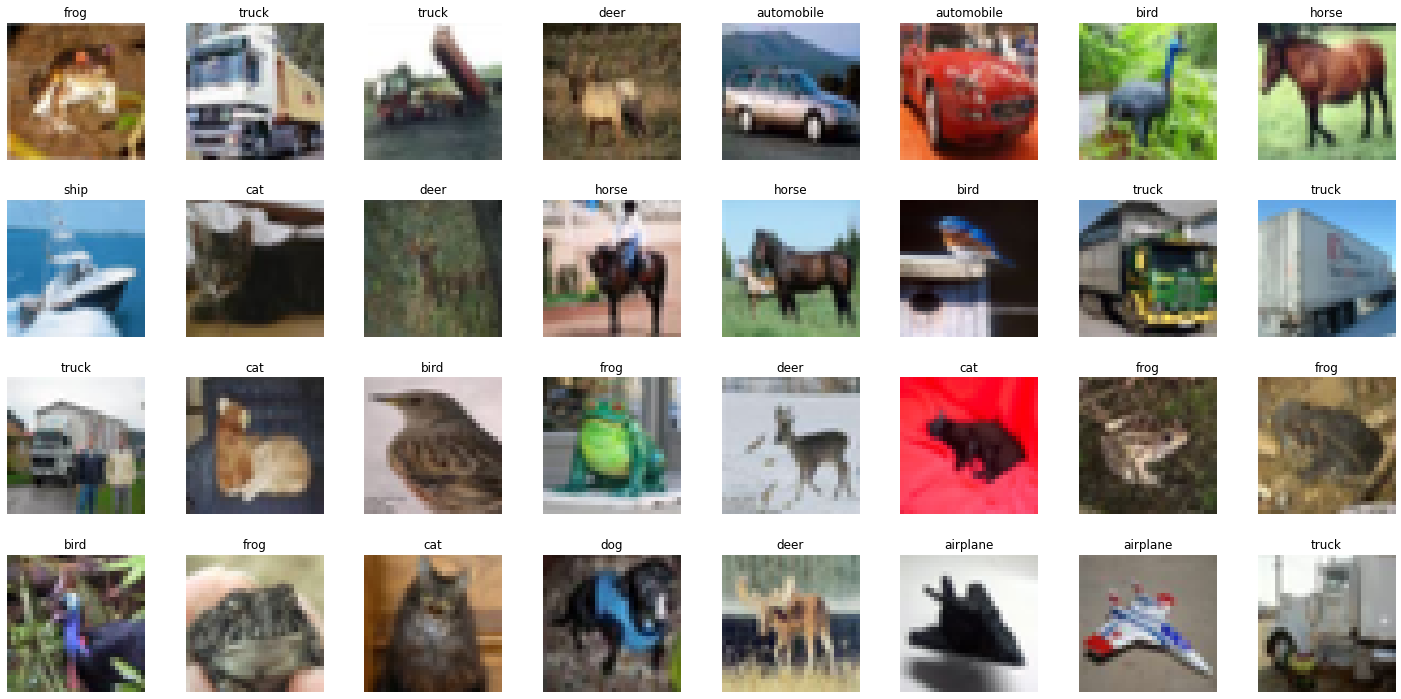

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline.

In [3]:
batch_size = 64

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10))) 
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))              # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors. Dimension of 10 possible targets.
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

**Task 2: Model**

The model is created as a CNN with 6 hidden layers + pooling layers inbetween and a ouput layer + pooling layer. To optimize the model, we implemented different methods.

*   Initialize the weigths with a glorot normal distribution (1) and the biases as zeros (2), to avoid vanshinig/exploding gradients.
*   Apply the loss regularization (L2) to the kernel weights matrix (3), to avoid overfitting. (3) is referenced in the computing of loss while training as well.
*   Apply the batch normalization (4) to get normalization of the drives and produce a more stable and faster network.
*   In order to be able to use all neurons equally efficiently, we have installed dropouts (5) in every second layer in the network.

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Description: The class Model describes a convolutional neural network with a feature extractor and a classifier.
#              @class variables: -
#              @object variables: conv_1, max_pool_1, conv_2, max_pool_2, conv_3, max_pool_3, conv_4, max_pool_4,
#                                 conv_5, max_pool_5, conv_6, max_pool_6, global_pool, output
#              @functions: call
class Model(Model): 
  
  def __init__(self):
    super(Model, self).__init__()
    
    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 80,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()         # (4)
    self.activ_1 = tf.keras.activations.relu                         
    self.max_pool_1 = tf.keras.layers.MaxPool2D(padding = 'same') 
    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.3)             # (5) Dropout after applying the Max 2D Pooling.
    self.conv_2 = tf.keras.layers.Conv2D(filters = 100,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()         # (4)
    self.activ_2 = tf.keras.activations.relu
    self.max_pool_2 = tf.keras.layers.MaxPool2D(padding = 'same')
    self.conv_3 = tf.keras.layers.Conv2D(filters = 120,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()         # (4)
    self.activ_3 = tf.keras.activations.relu
    self.max_pool_3 = tf.keras.layers.MaxPool2D(padding = 'same')
    self.dropout_3 = tf.keras.layers.Dropout(rate = 0.4)             # (5)
    self.conv_4 = tf.keras.layers.Conv2D(filters = 120,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_4 = tf.keras.layers.BatchNormalization()         # (4)
    self.activ_4 = tf.keras.activations.relu
    self.max_pool_4 = tf.keras.layers.MaxPool2D(padding = 'same')
    self.conv_5 = tf.keras.layers.Conv2D(filters = 100,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_5 = tf.keras.layers.BatchNormalization()         # (4)
    self.activ_5 = tf.keras.activations.relu      
    self.max_pool_5 = tf.keras.layers.MaxPool2D(padding = 'same')
    self.dropout_5 = tf.keras.layers.Dropout(rate = 0.3)             # (5)
    self.conv_6 = tf.keras.layers.Conv2D(filters = 80,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_6 = tf.keras.layers.BatchNormalization()         # (4)
    self.activ_6 = tf.keras.activations.relu
    self.max_pool_6 = tf.keras.layers.MaxPool2D(padding = 'same')

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()    
    self.dropout_7 = tf.keras.layers.Dropout(rate = 0.5)             # (5)
    self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)


  # Description: This function conducts one forward-step of the model. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
      x = self.conv_1(x)
      x = self.batch_norm_1(x, training)
      x = self.activ_1(x)
      x = self.max_pool_1(x)
      x = self.dropout_1(x, training)
      x = self.conv_2(x)
      x = self.batch_norm_2(x, training)
      x = self.activ_2(x)
      x = self.max_pool_2(x)
      x = self.conv_3(x)
      x = self.batch_norm_3(x, training)
      x = self.activ_3(x)
      x = self.max_pool_3(x)
      x = self.dropout_3(x, training)
      x = self.conv_4(x)
      x = self.batch_norm_4(x, training)
      x = self.activ_4(x)
      x = self.max_pool_4(x)
      x = self.conv_5(x)
      x = self.batch_norm_5(x, training)
      x = self.activ_5(x)
      x = self.max_pool_5(x)
      x = self.dropout_5(x, training)
      x = self.conv_6(x)
      x = self.batch_norm_6(x, training)
      x = self.activ_6(x)
      x = self.max_pool_6(x)    

      x = self.global_pool(x)
      x = self.dropout_7(x, training)
      x = self.output_layer(x)
      return x

**Task 3: Training**

In [5]:
# Description: This function trains an object of the class Model. It conducts a forward-step and the backpropagation 
#              throughout the network. Additionally, it determines the average training loss and accuracy.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test call of the CNN)
#              @returns: training_loss, training_accuracy
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction) + tf.math.reduce_sum(model.losses)   # (3)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of an object of the class Model.
#              @parameters: model, test_data, loss_fn, training (to differ between training and test call of the CNN)
#              @returns: test_loss, test_accuracy
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
Epoch 1
Epoch 2
Epoch 3


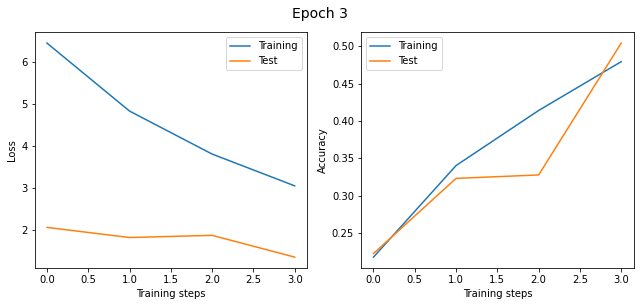

Epoch 4
Epoch 5


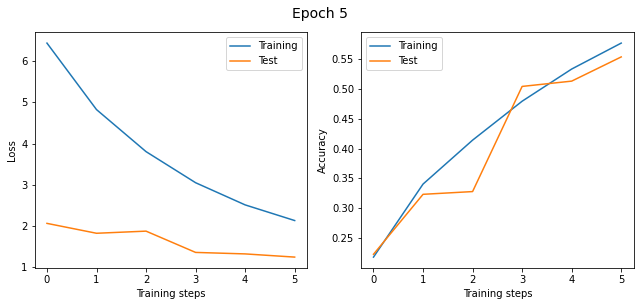

Epoch 6


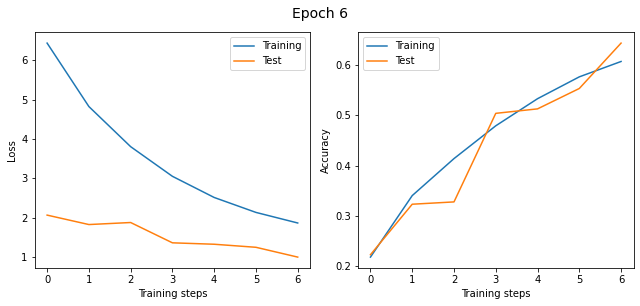

Epoch 7


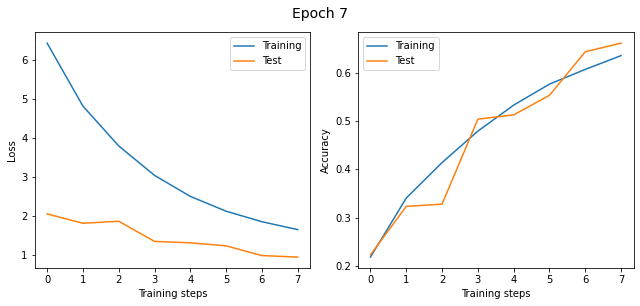

Epoch 8


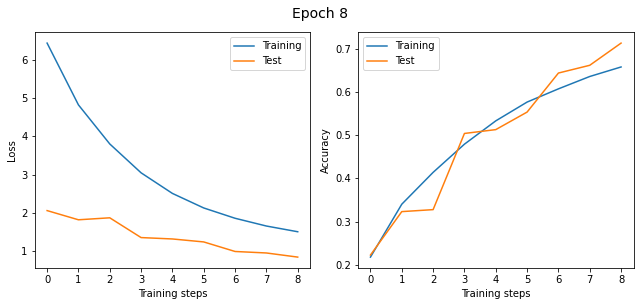

Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13


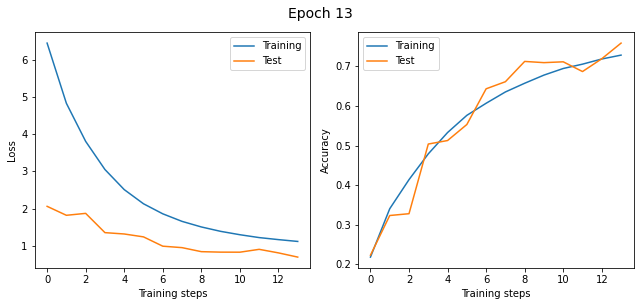

Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25


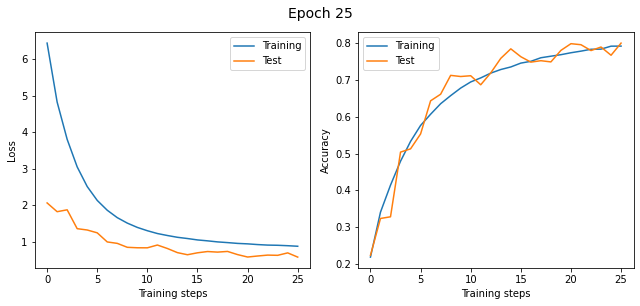

Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


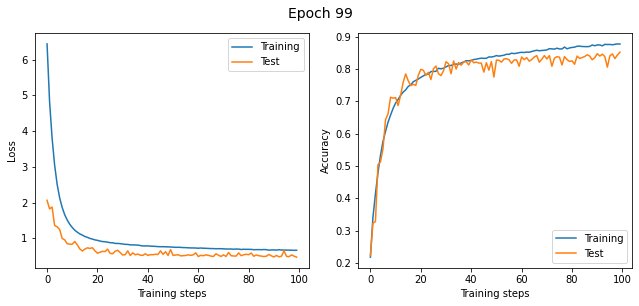

Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149


In [6]:
# Description: This part creates an object of the class Model called model and executes the training and testing of the model in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to get an overview of the course of the training during the training, the graph of the loss and the accuracy are output in the event of 
#              serious changes in accuracy (dynamic_threshold_train_visio).
tf.keras.backend.clear_session()

model = Model()
n_epochs = 150
learning_rate = 0.0001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

**Task 4: Visualization**

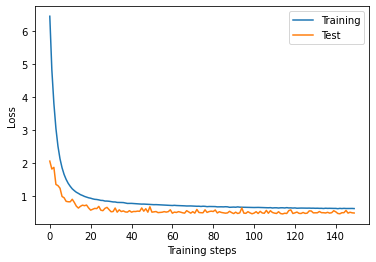

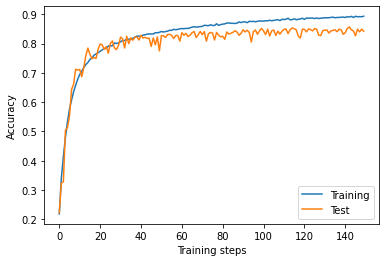

Epoch 0 test accuracy: 0.22312898089171976
Epoch 1 test accuracy: 0.3234474522292994
Epoch 2 test accuracy: 0.32802547770700635
Epoch 3 test accuracy: 0.5039808917197452
Epoch 4 test accuracy: 0.5128383757961783
Epoch 5 test accuracy: 0.553343949044586
Epoch 6 test accuracy: 0.6435111464968153
Epoch 7 test accuracy: 0.6614251592356688
Epoch 8 test accuracy: 0.7126791401273885
Epoch 9 test accuracy: 0.709593949044586
Epoch 10 test accuracy: 0.7116839171974523
Epoch 11 test accuracy: 0.6871019108280255
Epoch 12 test accuracy: 0.7194466560509554
Epoch 13 test accuracy: 0.7589570063694268
Epoch 14 test accuracy: 0.7848328025477707
Epoch 15 test accuracy: 0.7634355095541401
Epoch 16 test accuracy: 0.7487062101910829
Epoch 17 test accuracy: 0.7525875796178344
Epoch 18 test accuracy: 0.7493033439490446
Epoch 19 test accuracy: 0.7806528662420382
Epoch 20 test accuracy: 0.7988654458598726
Epoch 21 test accuracy: 0.7960788216560509
Epoch 22 test accuracy: 0.78015525477707
Epoch 23 test accuracy:

In [7]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

for epoch, test_acc in enumerate(test_accuracies):
   print("Epoch " + str(epoch) + " test accuracy: " + str(test_acc))